# Using TESVIS Fixed Sites Subsets Tool Application Programming Interface (API)

## Overview
The Terrestrial Ecology Subsetting & Visualization Services (TESViS) [Fixed Sites Subsets Tool](https://modis.ornl.gov/sites/) provides customized subsets and visualizations of several terrestrial ecology data products for selected field and flux tower sites worldwide. The Fixed Sites Tool also provides a standards-based REST (REpresentational State Transfer) [web service](https://modis.ornl.gov/data/modis_webservice.html) or API for programmatically accessing the subset data.

In this tutorial, we will learn how to get started with the Fixed Sites Subsets Tool API. We will retrieve subset datasets for a network of sites, perform simple analysis, and prepare visualizations. 

## Learning Objectives
- Use the TESVIS Fixed Sites Subsets Tool API to retrieve subsets from multiple datasets for site(s).
- Perform basic statistical analysis and visualizations in Python. 

## Tool Citation
Please cite the tool and API as:
>ORNL DAAC. 2018. Terrestrial Ecology Subsetting & Visualization Services (TESViS) Fixed Sites Subsets Tool. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1567

>ORNL DAAC. 2018. Terrestrial Ecology Subsetting & Visualization Services (TESViS) RESTful Web Service. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1600

## Requirements
1. Compute environment
This notebook can be run in any personal computing environment (e.g., desktop/laptops), on-premise solution (e.g., High-Performance Computing), or on the Cloud (e.g., Amazon Web Service).

2. Additional Requirements
This tutorial requires the following Python modules installed in your system: `requests`, `numpy`, `datetime`, `rasterio`, `geopandas`, `contextily`, `matplotllib`. To install the necessary Python modules, you can run:
```bash
pip install -r requests numpy datetime rasterio geopandas contextily matplotllib
```
## Import packages

In [1]:
import requests
import numpy as np
import rasterio
import contextily as ctx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from rasterio.plot import show
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

## Define a GET request function for MODIS API
Let's first define a function to retrieve subset data from the Fixed Sites Subsets Tool API, which we will use throughout this tutorial. The URIs for the API have the following syntax: `https://modis.ornl.gov/rst/api/{version}/{resourcepath}`. The current version is `v1`. A list of resource paths or endpoints is available on the [web service user interface page](https://modis.ornl.gov/rst/fixedsites_ui/).

All resources can be accessed via HTTP GET request with the required parameters. As an example, the following  `https://modis.ornl.gov/rst/api/v1/MOD13Q1/AmeriFlux/US-Ton/subset?startDate=A2003001&endDate=A2003030` will provide the subset data for the `MOD13Q1` product for a site `US-Ton` in the `AmeriFlux` network for the time period '2003-01-01' to '2003-01-30' (note the dates needs to be provided in the format (**A**YYYYJJJ). More information on the input parameters is also available in [this documentation](https://modis.ornl.gov/documentation.html#FixedSiteData).


In [2]:
# the API URI
base_api = 'https://modis.ornl.gov/rst/api/v1/'

def api(rp, **kwargs):
    """
    api function submits GET requests and returns json object.
    
    :rp: resource path
    :kwargs: optional parameters dictionary object
    """ 
    try:
        r = requests.get(f'{base_api}/{rp}', params=kwargs.get('params', False) )
        r.raise_for_status()
        return r.json()
    except requests.exceptions.RequestException as e:
        return {}

## List network names
Most networks (such as FLUXNET, NEON, etc) use their unique IDs for their sites. For some networks, the data and visualization from the Fixed Sites Tool can be accessed directly using the network IDs. These networks are available through the `networks` endpoint. 

Let's submit a request for network names and print them out.

In [3]:
# call api function
networks = api('networks').get('networks')
print(f'The following networks are represented in the Fixed Sites Subsets Tool: {", ".join(networks)}')

The following networks are represented in the Fixed Sites Subsets Tool: AERONET, AMERIFLUX, ASIAFLUX, BioSCape, BSRN, CForBio, CHINAFLUX, ECN, EOSLandValidation, EUROPEANFLUXES, FLUXNET, FORESTGEO, GVP, ICOS, LTER, NEON, NGEE-ARCTIC, NOAA-GMD, OZFLUX, PHENOCAM, SOLRAD, SURFRAD, SWISSFLUXNET, USCRN


## List all sites within a network
In the above list, one network is 'AMERIFLUX'. Let's retrieve all the sites in the AmeriFlux network. The `{network}/sites` (where 'network' is the network's name) resource path provides the list of all the sites within the network. This list includes 'network_siteid', 'network_sitename', 'network_siteurl', and its geolocation ('latitude' and 'longitude').

In [4]:
network = 'AMERIFLUX'
# create pandas dataframe from the api json response
sites_df = pd.DataFrame(api(f'{network}/sites').get('sites'))
sites_df

,network_siteid,network_sitename,network_siteurl,network,latitude,longitude
0,AR-CCa,Carlos Casares agriculture,https://ameriflux.lbl.gov/sites/siteinfo/AR-CCa,AMERIFLUX,-35.621000,-61.318100
1,AR-CCg,Carlos Casares grassland,https://ameriflux.lbl.gov/sites/siteinfo/AR-CCg,AMERIFLUX,-35.924400,-61.185500
2,AR-Cel,CELPA Mar Chiquita BA,https://ameriflux.lbl.gov/sites/siteinfo/AR-Cel,AMERIFLUX,-37.702800,-57.419200
3,AR-TF1,Rio Moat bog,https://ameriflux.lbl.gov/sites/siteinfo/AR-TF1,AMERIFLUX,-54.973300,-66.733500
4,AR-TF2,Rio Pipo bog,https://ameriflux.lbl.gov/sites/siteinfo/AR-TF2,AMERIFLUX,-54.826852,-68.454856
...,...,...,...,...,...,...
629,US-xYE,NEON Yellowstone Northern Range (Frog Rock) (Y...,https://ameriflux.lbl.gov/sites/siteinfo/US-xYE,AMERIFLUX,44.953480,-110.539140
630,US-YK1,"Yukon-Kuskokwim Delta, Izaviknek-Kingaglia upl...",https://ameriflux.lbl.gov/sites/siteinfo/US-YK1,AMERIFLUX,61.272300,-163.222800
631,US-YK2,"Yukon-Kuskokwim Delta, Izaviknek-Kingaglia upl...",https://ameriflux.lbl.gov/sites/siteinfo/US-YK2,AMERIFLUX,61.254800,-163.259000
632,US-Ylw,Yellow Cab urban,https://ameriflux.lbl.gov/sites/siteinfo/US-Ylw,AMERIFLUX,29.789400,-95.353600


## Plot sites over a map
In the above table, we see that there are 634 sites within the AmeriFlux network. The table also provides spatial coordinates of the sites, which we can use to plot the sites over a base map.

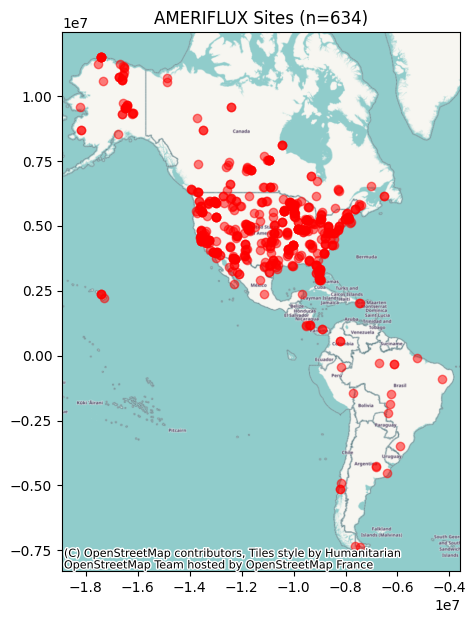

In [5]:
# create a geopandas dataframe
sites_gdf = gpd.GeoDataFrame(sites_df, geometry=gpd.points_from_xy(sites_df.longitude, sites_df.latitude))
# assign the wgs84 coordinate reference system
sites_gdf.crs="EPSG:4326"
# converting CRS to that of contextily basemaps
sites_gdf = sites_gdf.to_crs(epsg=3857)
# plotting the sites
ax = sites_gdf.plot(alpha=0.5, color='red',figsize=(7, 7))
# adding plot titles
ax.set_title(f'{network} Sites (n={len(sites_df.index)})')
# adding contextily basemap
ctx.add_basemap(ax)
plt.show()

For the next section of this tutorial, we will focus on only one site (`AR-TF1`) from the above list of all AmeriFlux sites. Let's print the details of this site below. 

In [6]:
network_siteid = 'AR-TF1'
s_gdf = sites_gdf[sites_gdf.network_siteid == network_siteid]
s_gdf

,network_siteid,network_sitename,network_siteurl,network,latitude,longitude,geometry
3,AR-TF1,Rio Moat bog,https://ameriflux.lbl.gov/sites/siteinfo/AR-TF1,AMERIFLUX,-54.9733,-66.7335,POINT (-7428739.239 -7356685.911)


The AmeriFlux Flux Tower site "Rio Moat bog" is in Argentina. The site is near a permanent mixture of water and herbaceous or woody vegetation that covers extensive areas. The tower collects data on [eddy covariance](https://www.tern.org.au/what-is-an-eddy-covariance-flux-tower) fluxes, and more information about this site is available on the [AmeriFlux website](https://ameriflux.lbl.gov/sites/siteinfo/AR-TF1).

Let's plot the location of the US-OWC site over a map.

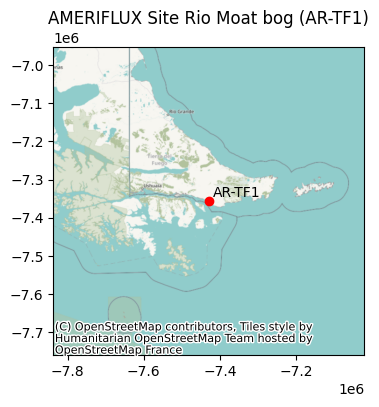

In [7]:
# plot the location
ax = s_gdf.plot(color='red', figsize=(6, 4))
# add the label
ax.annotate(f'{network_siteid}', xy=(s_gdf.geometry.x.values[0], s_gdf.geometry.y.values[0]), 
            xytext=(3, 3), textcoords="offset points")
ax.set_title(f'{network} Site {s_gdf.network_sitename.values[0]} ({network_siteid})')
ctx.add_basemap(ax)
plt.show()

## Find available data products for the site
All the products may not be available for all the sites. For example, the subset data for the [Daymet](https://doi.org/10.3334/ORNLDAAC/2129) product is only available for North America. Similarly, the [GEDI subsets](https://daac.ornl.gov/gedi) are only available for the sites within 52N to 52S degrees latitudes.

Let's find all the subset data products available for the site 'AR-TF1' in the Fixed Sites Subsets Tool. We will use the `products` endpoint to retrieve a list of all products available in the TESVIS tool. We will also use `{product}/{network}/{network_siteid}/dates` to retrieve the available dates for the subset data for a product for the site.

In [8]:
# get list of all products 
products_df = pd.DataFrame(api('products').get('products'))
# initialize list to store pandas dataframe
dates_df = []
# loop through products
for p in products_df['product'].tolist():
    # create pandas list of products and available date for the site
    df = pd.DataFrame(api(f'{p}/{network}/{network_siteid}/dates').get('dates'))
    df['product'] = p
    dates_df.append(df)
# concatenate into a single dataframe
dates_df = pd.concat(dates_df, axis=0)
# get the list of unique products
prod_list = dates_df["product"].unique()
print(f'A total of {len(prod_list)} products are available for the site {network_siteid}: {", ".join(prod_list)}')

A total of 38 products are available for the site AR-TF1: MCD12Q1, MCD12Q2, MCD15A2H, MCD15A3H, MCD64A1, MOD09A1, MOD11A2, MOD13Q1, MOD14A2, MOD15A2H, MOD16A2, MOD16A2GF, MOD17A2H, MOD17A2HGF, MOD17A3HGF, MOD21A2, MOD44B, MYD09A1, MYD11A2, MYD13Q1, MYD14A2, MYD15A2H, MYD16A2, MYD16A2GF, MYD17A2H, MYD17A2HGF, MYD17A3HGF, MYD21A2, SIF005, SIF_ANN, SPL3SMP_E, SPL4CMDL, VNP09A1, VNP09H1, VNP13A1, VNP15A2H, VNP21A2, VNP22Q2


## Retrieve vegetation index subsets time-series for a site
Of the products listed above, three products provide [vegetation indices](https://modis.gsfc.nasa.gov/data/dataprod/mod13.php). In this section of the tutorial, we will retrieve and visualize the time series vegetation indices values for the site 'AR-TF1'.  

The vegetation index products have `13` in their product names like 'MOD13Q1' and 'VNP13A1'. Let's filter the product dataframe (`products_df`) and print the product names and descriptions below.

In [9]:
# vegetation index MODIS/VIIRS products have 13Q or 13A 
vi_products = list(filter(lambda x: '13' in x, prod_list))
products_df[products_df['product'].isin(vi_products)]

,product,description,frequency,resolution_meters
16,MOD13Q1,MODIS/Terra Vegetation Indices (NDVI/EVI) 16-D...,16-Day,250
28,MYD13Q1,MODIS/Aqua Vegetation Indices (NDVI/EVI) 16-Da...,16-Day,250
43,VNP13A1,VIIRS/S-NPP Vegetation Indices (NDVI/EVI) 16-D...,16-Day,500


The two vegetation index products available are from MODIS instruments [MOD13Q1](https://doi.org/10.5067/MODIS/MOD13Q1.061) on Terra and [MYD13Q1](https://doi.org/10.5067/MODIS/MYD13Q1.061) on Aqua. The third product, [VNP13A1](https://doi.org/10.5067/VIIRS/VNP13A1.001), is from the VIIRS instrument on the Suomi-NPP platform. All three products are 16-day composites computed over a 250m grid for the MODIS vegetation index products and at 500m grids for the VIIRS products.

For MODIS and VIIRS products, the Fixed Sites Tool provides subsets for "raw", "filtered", and "statistics". The "filtered" subsets are available for the science data bands with a scale factor and quality filters applied. The "statistics" summarizes the data for each time step for science data bands. Please read the [documentation](https://modis.ornl.gov/documentation.html#data_format) to learn about the data formats.

Let's retrieve subset statistics for all three vegetation index products for the period 2000-2022 for the site 'AR-TF1'. We will be using the API endpoint `{product}/{network}/{network_siteid}/subsetStatistics`, which also needs two required parameters: `startDate` and `endDate`.

In [10]:
date1 = 'A2000001' # start date in AYYYYJJJ format
date2 = 'A2022365' # end date
stat_df = []
# loop over 3 vegetation index products
for p in vi_products:
    # retrieve the dataset and save to a pandas dataframe
    df = pd.DataFrame(api(f'{p}/{network}/{network_siteid}/subsetStatistics', 
                           params={'startDate': date1, 'endDate': date2}).get('statistics'))
    # adding product column
    df['product'] = p
    stat_df.append(df)
stat_df = pd.concat(stat_df, axis=0)
# converting calendar_date column to datetime object
stat_df.calendar_date = pd.to_datetime(stat_df.calendar_date)
# setting calendar_date column as the dataframe index
stat_df.set_index('calendar_date', inplace=True)
stat_df

,modis_date,band,value_center,value_min,value_max,value_sum,value_range,value_mean,value_variance,value_stddev,pixels_total,pixels_pass,pixels_pass_rel,proc_date,product
calendar_date,,,,,,,,,,,,,,,
2000-02-18,A2000049,250m_16_days_EVI,F,0.1575,0.5480,39.3656,0.3905,0.4279,0.0080,0.0896,1089,92,8.45,2020041154200,MOD13Q1
2000-02-18,A2000049,250m_16_days_NDVI,F,0.3483,0.9335,72.7188,0.5852,0.7904,0.0107,0.1036,1089,92,8.45,2020041154200,MOD13Q1
2000-03-05,A2000065,250m_16_days_EVI,F,0.0464,0.5791,231.6011,0.5327,0.4265,0.0032,0.0564,1089,543,49.86,2020040140951,MOD13Q1
2000-03-05,A2000065,250m_16_days_NDVI,F,0.4891,0.8689,420.3650,0.3798,0.7742,0.0017,0.0412,1089,543,49.86,2020040140951,MOD13Q1
2000-03-21,A2000081,250m_16_days_EVI,0.3268,0.0444,0.6604,180.9474,0.6160,0.3934,0.0091,0.0952,1089,460,42.24,2020041152233,MOD13Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,A2022353,500_m_16_days_EVI2,0.4002,-0.0108,0.6396,87.7043,0.6504,0.4544,0.0278,0.1668,289,193,66.78,2023010191152,VNP13A1
2022-12-19,A2022353,500_m_16_days_NDVI,0.6179,-0.0681,0.8780,126.4436,0.9461,0.6551,0.0446,0.2113,289,193,66.78,2023010191152,VNP13A1
2022-12-27,A2022361,500_m_16_days_EVI,0.5166,-0.0108,0.6073,80.9581,0.6181,0.4173,0.0234,0.1530,289,194,67.13,2023013080040,VNP13A1


Let's print a summary of band and product names from the above dataframe.

In [11]:
pd.DataFrame(stat_df.groupby(['product', 'band']).size().rename('Count'))

Count
product band                     
MOD13Q1 250m_16_days_EVI      526
        250m_16_days_NDVI     526
MYD13Q1 250m_16_days_EVI      472
        250m_16_days_NDVI     472
VNP13A1 500_m_16_days_EVI     504
        500_m_16_days_EVI2    504
        500_m_16_days_NDVI    504

For this tutorial, we will only plot 'NDVI' (normalized difference vegetation index) and 'EVI' (enhanced vegetation index) bands, which are available for all three products. We will exclude the EVI2 (enhanced vegetation index-2) band, only available for the VIIRS vegetation index product VNP13A1.

Before we plot the vegetation indices layers, let's define a function called 'convertdate' to convert the modis date in 'AYYYYJJJ' format to 'YYYY-MM-DD'. We will reuse this function later throughout the tutorial.

In [12]:
def convertdate(modis_date):
    """
    convertdate function convert string in AYYYYJJJ and returns string as YYYY-MM-DD.

    :modis_date: string in AYYYYJJJ format
    """ 
    return datetime.strptime(modis_date[1:], '%Y%j').strftime('%Y-%m-%d')

Now, let's plot the mean statistics time series of NDVI and EVI bands from these three data products.

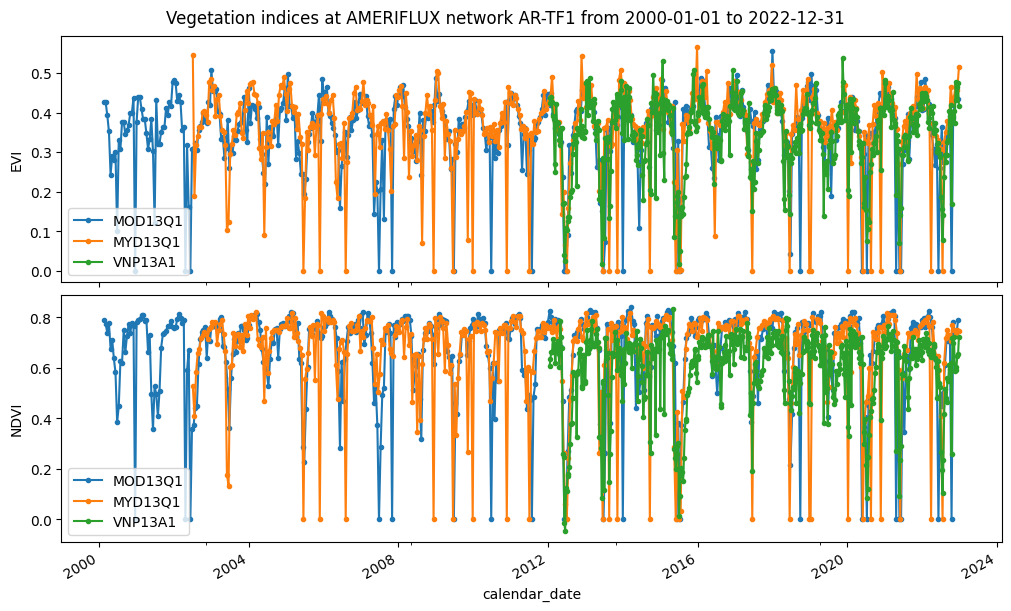

In [13]:
# EVI and NDVI bands
bands = ['EVI', 'NDVI']
n = 0
fig, axes = plt.subplots(nrows=2, ncols=1, sharex="all", figsize=(10, 6), constrained_layout=True)
for b in bands:
    # group by bands
    stat_fpar_df = stat_df[stat_df['band'].str.endswith(b)].groupby('product')
    # plot mean values
    stat_fpar_df['value_mean'].plot(style='.-', legend=True, ax=axes[n])
    # label y axis
    axes[n].set_ylabel(b)
    n += 1
fig.suptitle(f'Vegetation indices at {network} network {network_siteid} from {convertdate(date1)} to {convertdate(date2)}', 
             fontsize=12)
plt.show()

As we see above, all the vegetation indices from all three products more or less align with each other. We also see that the Terra product (MOD13Q1) starts in 2000, the Aqua product (MYD13Q1) starts in 2002, and the VIIRS product (VNP13A1) starts 2012. The VIIRS product can serve as a continuity product when MODIS instruments [drift from their traditional orbits](https://www.earthdata.nasa.gov/learn/articles/modis-to-viirs-transition).

## Retrieve vegetation indices subsets for a single date for a site
The Fixed Sites Tool provides the subset with a buffer size of about 8 km x 8km around the site location. In the following section, we will retrieve a single date of subset data and visualize the grids. This kind of visualization provides insights on the spatial variabilities around the site.

We will be using the API endpoints `{product}/{network}/{network_siteid}/subset` and `{product}/{network}/{network_siteid}/subsetFiltered` to retrieve the subset data. We will also pass the required date parameters (`startDate`, `endDate`) and an optional `band` parameter.

The `subsetFiltered` API returns the grid values that do not pass the filtering criteria as a string 'F'. We will create a function that converts the string 'F' to a NaN value. We will apply this function to the API subset dataset throughout the tutorial.

In [14]:
def setnan(ds):
    """
    setnan function replaces instances of 'F' with a NaN value.
    
    :ds: list of string
    """ 
    return [np.nan if x=='F' else x for x in ds]

Let's say we are interested in a single date, '2017-05-09' (or A2017129 in modis style date). Let's retrieve the subset for NDVI bands for the two products MOD13Q1 and VNP13A1. We will first save the subset grid as a GeoTiff file using the 'rasterio' Python module.

In [15]:
date3 = 'A2017129'
# NDVI bands
d = {'MOD13Q1': '250m_16_days_NDVI', 'VNP13A1': '500_m_16_days_NDVI'}
# sinusoidal projection
crs = '+proj=sinu +R=6371007.181 +nadgrids=@null +wktext'
# retrieve raw and filtered data
otypes = ['raw', 'filtered']
# loop over bands
for product, band in d.items():
    # define parameters
    params = {'startDate': date3, 'endDate':date3, 'band':band}
    for ot in otypes:
        subtxt = 'subset' if ot=='raw' else 'subsetFiltered'
        # submit API get request
        subset = api(f'{product}/{network}/{network_siteid}/{subtxt}', params=params)
        # get cell size from json response
        cellsize = float(subset['cellsize'])
        # affine transformation
        transform = rasterio.transform.from_origin(float(subset['xllcorner']), 
                                                   float(subset['yllcorner']), 
                                                   cellsize, -cellsize)
        # reading the gridded dataset into an array
        if ot=='raw':
            # raw dataset as int datatype
            data = np.array(subset['subset'][0]['data'], dtype = 'int32')
        if ot=='filtered':
            # filtered dataset as float datatype
            data = setnan(subset['subset'][0]['data'])
            data = np.asarray(data, dtype='float32')
        # create a grid with correct orientation
        nrows = int(subset['nrows'])
        ncols = int(subset['ncols'])
        data  = np.flipud(data.reshape(nrows, ncols))
        # writing to geotiff
        with rasterio.open(f'output/{product}_{band}_{date3}_{ot}.tif', 'w', 
                           driver='GTiff', 
                           height=nrows, width=ncols, 
                           count=1,
                           dtype=data.dtype,
                           crs=crs, transform=transform) as grid:
            grid.write(data, 1)

Now, let's visualize the GeoTiff files we created above.

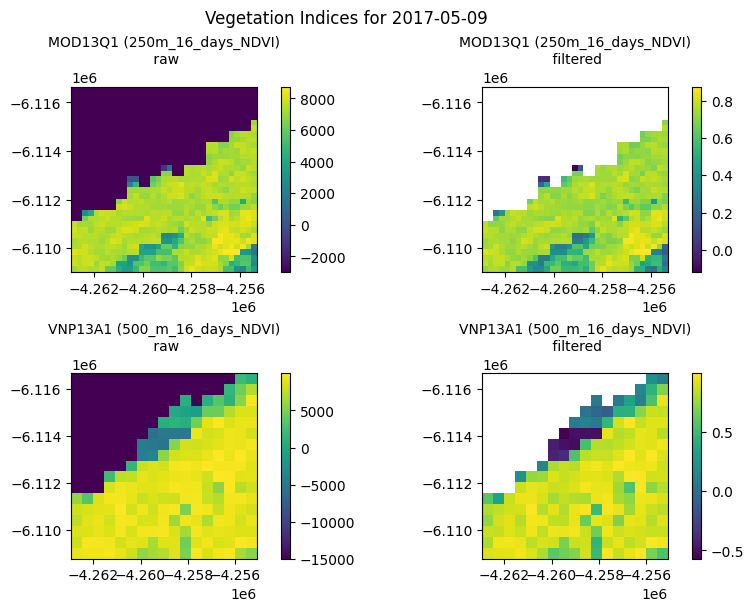

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), constrained_layout=True)
n=0
for product, band in d.items():
    k=0
    for ot in otypes:
        with rasterio.open(f'output/{product}_{band}_{date3}_{ot}.tif') as src:
            grid2 = src.read(1, masked=True)
            # color bar
            fig.colorbar(ax.imshow(grid2), ax=axes[n, k])
            rasterio.plot.show(grid2, transform=src.transform, ax=axes[n, k])
            axes[n, k].set_title(f'{product} ({band})\n {ot}', fontsize=10)
        k+=1
    n+=1
fig.suptitle(f'Vegetation Indices for {convertdate(date3)}', fontsize=12)
plt.show()

As we see in the above figures, the "raw" grids (in the left column) includes grid values that are not scaled and not quality filtered. The "filtered" grids in the right column shows the vegetation index values correctly as well as masks out water body. We also notice that 250m MOD13Q1 NDVI shows a better spatial variability as compared to a 500m grid from VNP13A1.

## Retrieve vegetation index subset for all AmeriFlux sites
In the following section of the tutorial, instead of a single site, we will retrieve vegetation index subsets for all AmeriFlux sites and look at spatial patterns of vegetation indices across North and South America for a single date. We will also retrieve subsets for a land cover type dataset for all the sites and look at how the vegetation index varies across land cover types.

We will be using the API endpoint `{product}/{network}/{network_siteid}/subsetFiltered` to retrieve the filtered subset data. We will also pass the required date parameters (`startDate`, `endDate`) and an optional `band` parameter.

First, let's retrieve the subset for the band `500_m_16_days_NDVI` from the data product `VNP13A1`. Since this product has a grid size of 500m x 500m, for a subset area of 8km x 8km, there should be 289 grids.

In [17]:
product = 'VNP13A1'
band = '500_m_16_days_NDVI'
params = {'startDate': date3, 'endDate':date3, 'band':band}
ndvi_df = []
# loop through all Ameriflux sites
for sid in sites_gdf.network_siteid.tolist():
    data_json = api(f'{product}/{network}/{sid}/subsetFiltered', params=params).get('subset')
    if data_json:
        df = pd.DataFrame(setnan(data_json[0].get('data')), columns =[sid])
        ndvi_df.append(df)
ndvi_df = pd.concat(ndvi_df, axis=1)
ndvi_df

,AR-CCa,AR-CCg,AR-Cel,AR-TF1,AR-TF2,BR-CMT,BR-CST,BR-Cui,BR-Ma2,BR-Npw,...,US-xTR,US-xUK,US-xUN,US-xWD,US-xWR,US-xYE,US-YK1,US-YK2,US-Ylw,US-YNS
0,0.4585,0.5453,0.7085,0.9164,0.0237,0.4954,0.5400,0.5262,0.9493,0.8043,...,0.5441,0.8996,0.4894,0.3753,0.7636,0.5211,0.3463,0.5035,0.5476,0.6835
1,0.4699,0.6048,0.6250,0.9309,-0.0772,0.4675,0.6893,0.7642,0.9037,0.6809,...,0.5441,0.8794,0.6024,0.3503,0.8326,0.4826,0.4854,0.4641,0.5394,0.7012
2,0.4229,0.6317,0.5536,0.9336,0.2030,0.5898,0.7267,0.6815,0.9364,0.7366,...,0.5312,0.8836,0.5957,0.3303,0.8123,0.5302,0.5152,0.4497,0.4648,0.7012
3,0.5126,0.6495,0.5513,0.9669,0.3955,0.8304,0.6090,0.6452,0.8892,0.7366,...,0.5036,0.8783,0.5417,0.3133,0.7807,0.5886,0.5032,0.3352,0.3903,0.7002
4,0.5341,0.6104,0.4797,0.9070,0.7777,0.7578,0.5945,0.5628,0.8707,0.7831,...,0.5179,0.8236,0.5424,0.4262,0.8081,0.5330,0.4905,0.5562,0.4937,0.6672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,0.6316,0.6254,0.3991,NaN,0.7478,0.8171,0.5822,0.8399,0.8994,0.8482,...,0.6490,0.5989,0.5572,0.5353,0.8313,0.5789,0.5328,0.5263,0.3725,0.6827
285,0.6319,0.5961,0.5461,NaN,0.7371,0.6292,0.7273,0.3058,0.8411,0.7493,...,0.6402,0.7076,0.5364,0.3772,0.8369,0.5595,0.5319,0.5135,0.2518,0.6334
286,0.6247,0.5963,0.5120,NaN,0.0634,0.5001,0.5921,0.6181,0.8653,0.7939,...,0.6283,0.7672,0.4736,0.2227,0.8462,0.2161,0.5265,0.5105,0.4644,0.6273
287,0.5934,0.5914,NaN,0.2134,0.5000,0.4663,0.5912,0.4185,0.9045,0.8401,...,0.6203,0.7727,0.5238,0.3249,0.8436,0.2161,0.5275,0.5205,0.4644,0.7000


In the above table, the sites are organized by columns, and the grid values (n=289) are in the rows.

Now, let's also retrieve a land cover type subset all the AmeriFlux Sites. MODIS data product [MCD12Q1](https://doi.org/10.5067/MODIS/MCD12Q1.061) provides landcover types derived using supervised classifications of MODIS Terra and Aqua reflectance data. We will use the band `LC_Type1`, which provides land cover type Cover based on the annual International Geosphere-Biosphere Programme (IGBP) classification scheme.

In [18]:
product2 = 'MCD12Q1'
band2 = 'LC_Type1'
date4 = 'A2017001'
params = {'startDate': date4, 'endDate':date4, 'band':band2}
cover_df = []
for sid in sites_gdf.network_siteid.tolist():
    data_json = api(f'{product2}/{network}/{sid}/subset', params=params).get('subset')
    if data_json:
        df = pd.DataFrame(setnan(data_json[0].get('data')), columns =[sid])
        cover_df.append(df)
cover_df = pd.concat(cover_df, axis=1)
cover_df

,AR-CCa,AR-CCg,AR-Cel,AR-TF1,AR-TF2,BR-CMT,BR-CST,BR-Cui,BR-Ma2,BR-Npw,...,US-xTR,US-xUK,US-xUN,US-xWD,US-xWR,US-xYE,US-YK1,US-YK2,US-Ylw,US-YNS
0,10.0,10.0,9.0,1.0,16.0,12.0,10.0,11.0,2.0,2.0,...,5.0,4.0,4.0,12.0,1.0,10.0,17.0,10.0,13.0,1.0
1,10.0,10.0,9.0,1.0,10.0,12.0,10.0,11.0,2.0,9.0,...,5.0,4.0,4.0,12.0,1.0,10.0,7.0,7.0,13.0,1.0
2,17.0,9.0,11.0,1.0,10.0,12.0,10.0,10.0,2.0,9.0,...,8.0,9.0,5.0,12.0,1.0,8.0,7.0,7.0,13.0,8.0
3,17.0,9.0,11.0,1.0,5.0,12.0,10.0,10.0,2.0,9.0,...,8.0,9.0,4.0,12.0,1.0,8.0,7.0,11.0,13.0,8.0
4,10.0,9.0,11.0,1.0,5.0,12.0,10.0,10.0,2.0,8.0,...,4.0,10.0,4.0,12.0,1.0,10.0,7.0,17.0,13.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,10.0,10.0,9.0,17.0,17.0,10.0,10.0,8.0,2.0,2.0,...,4.0,12.0,5.0,12.0,1.0,9.0,7.0,7.0,13.0,8.0
285,10.0,9.0,9.0,17.0,17.0,10.0,10.0,11.0,2.0,9.0,...,4.0,12.0,8.0,12.0,1.0,10.0,7.0,7.0,13.0,8.0
286,10.0,9.0,9.0,17.0,17.0,12.0,10.0,11.0,2.0,8.0,...,4.0,12.0,8.0,10.0,1.0,10.0,7.0,7.0,13.0,8.0
287,10.0,9.0,17.0,17.0,17.0,12.0,10.0,17.0,2.0,9.0,...,4.0,12.0,8.0,10.0,1.0,10.0,7.0,7.0,13.0,1.0


Because the MCD12Q1 product also has a grid size of 500m, the total number of grid cells in each subset is 289. The values above range from 1-17 to indicate different land cover types, and 255 is "unclassified". Let's define these land cover types in the following Python dictionary.

In [19]:
# IGBP classes
igbp = {1: 'Evergreen Needleleaf Forest', 2: 'Evergreen Broadleaf Forest', 3: 'Deciduous Needleleaf Forest',  
           4: 'Deciduous Broadleaf Forest', 5: 'Mixed Forests', 6: 'Closed Shrublands', 7: 'Open Shrublands', 
           8: 'Woody Savannas', 9: 'Savannas', 10: 'Grasslands', 11: 'Permanent Wetlands', 12: 'Croplands', 
           13:'Urban and Built-Up', 14: 'Cropland/Natural Vegetation Mosaic', 15: 'Snow and Ice', 
           16: 'Barren or Sparsely Vegetated', 17: 'Water Bodies', 255: 'Unclassified'}

Now, let's plot the mean NDVI and the median land cover type values for all AmeriFlux sites.

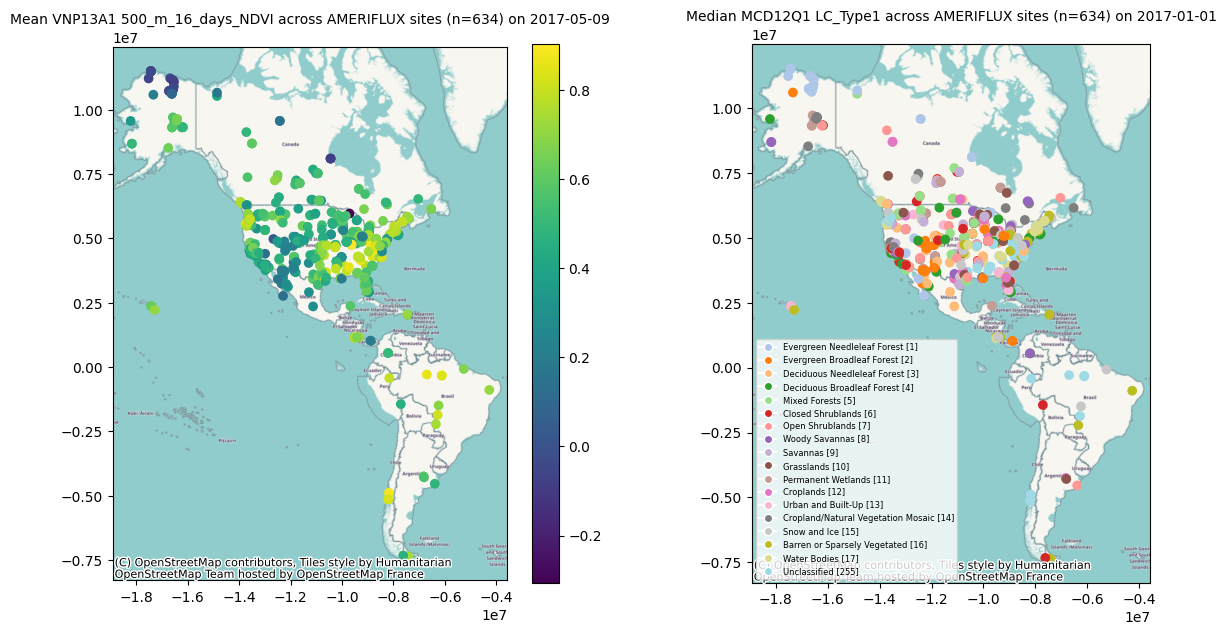

In [20]:
# subset the sites_gdf pandas frame with only AmeriFlux sites
site_gdf = sites_gdf[sites_gdf.network_siteid.isin(ndvi_df.columns.values.tolist())]
site_gdf = site_gdf.set_index('network_siteid')

# calculate the mean NDVI values for each site and add as a new column to site_gdf
dfx = pd.DataFrame(ndvi_df.mean(axis=0), columns=[band])
dfx.index.name = 'network_siteid'
site_gdf = pd.concat([site_gdf, dfx], axis=1)

# calculate the median landcover values for each site and add as a new column to site_gdf
dfx = pd.DataFrame(cover_df.median(axis=0), columns=[band2])
dfx.index.name = 'network_siteid'
site_gdf = pd.concat([site_gdf, dfx], axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# plot NDVI
site_gdf.plot(column=band, cmap='viridis', legend=True, ax = axes[0])
axes[0].set_title(f'Mean {product} {band} across {network} sites (n={len(site_gdf.index)}) on {convertdate(date3)}', fontsize=10)
ctx.add_basemap(axes[0])

# following steps are needed to create a legend for land cover types
cmap = colormaps.get_cmap('tab20')
patchList = []
tab20 = []
for i in igbp:
    key = igbp[i]
    label = f'{key} [{str(i)}]'
    data_key = Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=cmap(i), markersize=6)
    tab20.append(cmap(i))
    patchList.append(data_key)
newcmp = ListedColormap(tab20)

# plot land cover types
site_gdf.plot(column=band, categorical=True, cmap=newcmp, legend=True, ax=axes[1])
axes[1].set_title(f'Median {product2} {band2} across {network} sites (n={len(site_gdf.index)}) on {convertdate(date4)}', fontsize=10)
axes[1].legend(handles=patchList, facecolor="white", fontsize=6)
ctx.add_basemap(axes[1])
plt.show()

Now, we will compute how the NDVI values varies by different land cover types, and plot a bar diagram showing their mean values

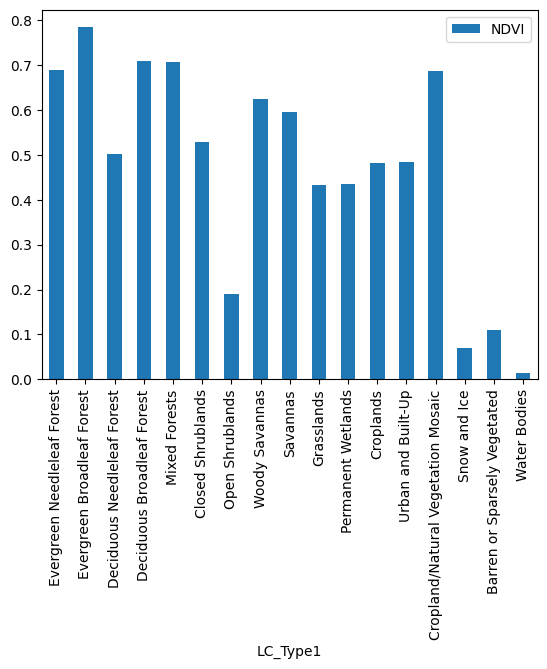

In [21]:
# initialize empty data frame
df = pd.DataFrame()
df['NDVI']=ndvi_df.stack()
df['LC_Type1']=cover_df.stack()
# compute means
df.groupby('LC_Type1').mean().plot.bar()
# create a dataframe with class names
lc_df = pd.DataFrame.from_dict(igbp,orient='index', columns=['IGBP'])
# label x axis ticks
plt.xticks(ticks = range(0,17),labels = lc_df.IGBP[:-1], rotation = 'vertical')
plt.show()